# Interpretability Analysis of TB Classification Models

This notebook focuses on analyzing and comparing the interpretability of the original and finetuned TB chest X-ray classification models. Unlike the previous notebooks that evaluate performance metrics like accuracy and F1 score, this notebook focuses solely on how well the models explain their decisions through attention mechanisms.

We will analyze:
1. Attention map quality and focus areas
2. Intersection over Union (IoU) between attention maps
3. Pearson correlation between attention maps
4. Consistency of explanations across samples
5. Comparison between original and finetuned model explanations

In [1]:
# Setup and Import Libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy import stats
from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

sys.path.append('..')
from attention_model import SimpleAttentionCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [2]:
# Define paths and load models
ORIGINAL_MODEL_PATH = "../model/tb_chest_xray_attention_best.pt"
FINETUNED_MODEL_PATH = "../finetuning/tb_chest_xray_refined_20250318_034728.pt"
ORIGINAL_TEST_DATA_PATH = "../model/tuberculosis-dataset"
NEW_TEST_DATA_PATH = "../Testing/test_dataset"
METADATA_PATH = "../Testing/test_dataset/MetaData.csv"

# Check if the files and directories exist
print(f"Original model exists: {os.path.exists(ORIGINAL_MODEL_PATH)}")
print(f"Finetuned model exists: {os.path.exists(FINETUNED_MODEL_PATH)}")
print(f"Original test dataset exists: {os.path.exists(ORIGINAL_TEST_DATA_PATH)}")
print(f"New test dataset exists: {os.path.exists(NEW_TEST_DATA_PATH)}")

# Load models
def load_model(model_path):
    model = SimpleAttentionCNN().to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None

# Load both models
original_model = load_model(ORIGINAL_MODEL_PATH)
finetuned_model = load_model(FINETUNED_MODEL_PATH)

# Set models to evaluation mode
if original_model:
    original_model.eval()
if finetuned_model:
    finetuned_model.eval()

## 1. Loading Test Datasets

We need to load both the original and new test datasets to evaluate interpretability across different data distributions.

In [3]:
# Load the original test dataset
def load_original_test_dataset(test_split=0.3, random_seed=42):
    """Load the original test dataset that was used to evaluate the model initially"""
    # Similar to the approach in original_dataset.ipynb
    all_images = []
    all_labels = []
    all_paths = []
    
    # Load Normal images (label = 0)
    normal_dir = os.path.join(ORIGINAL_TEST_DATA_PATH, "Normal")
    if os.path.isdir(normal_dir):
        for filename in os.listdir(normal_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(normal_dir, filename)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (256, 256))
                    all_images.append(img)
                    all_labels.append(0)
                    all_paths.append(path)
    
    # Load TB images (label = 1)
    tb_dir = os.path.join(ORIGINAL_TEST_DATA_PATH, "Tuberculosis")
    if os.path.isdir(tb_dir):
        for filename in os.listdir(tb_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(tb_dir, filename)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (256, 256))
                    all_images.append(img)
                    all_labels.append(1)
                    all_paths.append(path)
    
    # Convert to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    all_paths = np.array(all_paths)
    
    # Split into train and test using scikit-learn's train_test_split
    from sklearn.model_selection import train_test_split
    _, X_test, _, y_test, _, paths_test = train_test_split(
        all_images, all_labels, all_paths, test_size=test_split, random_state=random_seed
    )
    
    # Normalize images
    X_test = X_test.astype('float32') / 255.0
    
    print(f"Loaded {len(X_test)} original test images")
    print(f"Class distribution: {np.sum(y_test == 0)} Normal, {np.sum(y_test == 1)} TB")
    
    return X_test, y_test, paths_test

# Load the new test dataset
def load_new_test_dataset():
    """Load the new test dataset using information from MetaData.csv"""
    if not os.path.isfile(METADATA_PATH):
        print(f"MetaData CSV not found: {METADATA_PATH}")
        return None, None, None
        
    # Try to find the correct images directory
    images_dir = os.path.join(NEW_TEST_DATA_PATH, "Chest-X-Ray", "image")
    if not os.path.isdir(images_dir):
        # Search for image directory
        for root, dirs, _ in os.walk(NEW_TEST_DATA_PATH):
            for dir_name in dirs:
                if 'image' in dir_name.lower():
                    potential_dir = os.path.join(root, dir_name)
                    if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in os.listdir(potential_dir)):
                        images_dir = potential_dir
                        print(f"Found images directory: {images_dir}")
                        break
            if os.path.isdir(images_dir):
                break
                
    if not os.path.isdir(images_dir):
        print(f"Could not find images directory")
        return None, None, None
    
    try:
        # Read the CSV
        df = pd.read_csv(METADATA_PATH)
        
        # Extract data
        all_images = []
        all_labels = []
        all_paths = []
        
        # Check common file extensions
        extensions = ['.png', '.jpg', '.jpeg']
        
        # Process each row in metadata
        for _, row in df.iterrows():
            id_val = str(row['id'])
            label = int(row['ptb'])  # 1=TB, 0=Normal
            
            # Try all possible extensions
            img_path = None
            for ext in extensions:
                potential_path = os.path.join(images_dir, f"{id_val}{ext}")
                if os.path.isfile(potential_path):
                    img_path = potential_path
                    break
            
            # If not found, try finding by ID substring
            if img_path is None:
                for file in os.listdir(images_dir):
                    if id_val in file and file.lower().endswith(tuple(extensions)):
                        img_path = os.path.join(images_dir, file)
                        break
            
            if img_path and os.path.isfile(img_path):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (256, 256))
                    all_images.append(img)
                    all_labels.append(label)
                    all_paths.append(img_path)
        
        # Convert to numpy arrays
        all_images = np.array(all_images)
        all_labels = np.array(all_labels)
        all_paths = np.array(all_paths)
        
        # Normalize images
        all_images = all_images.astype('float32') / 255.0
        
        print(f"Loaded {len(all_images)} new test images")
        print(f"Class distribution: {np.sum(all_labels == 0)} Normal, {np.sum(all_labels == 1)} TB")
        
        return all_images, all_labels, all_paths
    
    except Exception as e:
        print(f"Error loading new test data: {e}")
        return None, None, None

# Create dataset class for attention map analysis
class InterpretabilityDataset(Dataset):
    def __init__(self, images, labels, paths):
        self.images = images  # Already preprocessed numpy arrays [0,1]
        self.labels = labels
        self.paths = paths
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        path = self.paths[idx]
        
        # Convert to tensor (1 channel for grayscale)
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        
        return img_tensor, torch.tensor(label, dtype=torch.float32), path

# Load datasets and create dataloaders
print("Loading original test dataset...")
orig_images, orig_labels, orig_paths = load_original_test_dataset()

print("\nLoading new test dataset...")
new_images, new_labels, new_paths = load_new_test_dataset()

# Create datasets and dataloaders
datasets = {}
dataloaders = {}

if orig_images is not None:
    datasets['original'] = InterpretabilityDataset(orig_images, orig_labels, orig_paths)
    dataloaders['original'] = DataLoader(datasets['original'], batch_size=16, shuffle=False)

if new_images is not None:
    datasets['new'] = InterpretabilityDataset(new_images, new_labels, new_paths)
    dataloaders['new'] = DataLoader(datasets['new'], batch_size=16, shuffle=False)

print("\nAvailable datasets for interpretability analysis:", list(dataloaders.keys()))

## 2. Functions for Generating Attention Maps

Define functions to generate and visualize attention maps from both models.

In [4]:
def generate_attention_maps(model, dataloader, model_name="Model"):
    """Generate attention maps for all images in the dataloader"""
    model.eval()
    all_imgs = []
    all_labels = []
    all_preds = []
    all_attn_maps = []
    all_img_paths = []
    
    with torch.no_grad():
        for batch in dataloader:
            images, labels, paths = batch
            images = images.to(device)
            
            # Forward pass to get attention maps
            outputs, attention_maps = model(images)
            
            # Get predictions
            preds = (outputs >= 0.5).cpu().numpy().flatten().astype(int)
            
            # Store original images, labels, predictions, attention maps, and paths
            all_imgs.extend(images.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_attn_maps.extend([attn.cpu().numpy() for attn in attention_maps])
            all_img_paths.extend(paths)
    
    print(f"Generated attention maps for {len(all_imgs)} images using {model_name}")
    
    return {
        'images': all_imgs,
        'labels': all_labels,
        'predictions': all_preds,
        'attention_maps': all_attn_maps,
        'image_paths': all_img_paths
    }

def preprocess_heatmap(heatmap, smooth=True, sigma=1.0):
    """Preprocess attention heatmap for better visualization and comparison"""
    # Ensure the heatmap is in a valid range
    heatmap = np.abs(heatmap)  # Take absolute values
    
    # Apply smoothing if required
    if smooth:
        heatmap = gaussian_filter(heatmap, sigma=sigma)
    
    # Normalize to [0, 1]
    if np.max(heatmap) > 0:  # Avoid division by zero
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    
    return heatmap

def visualize_attention_maps(original_img, heatmap, prediction, label, title="Attention Map"):
    """Visualize an image with its attention heatmap overlay"""
    # Convert single-channel grayscale to 3-channel for overlay
    img_3channel = np.repeat(original_img[0, :, :, np.newaxis], 3, axis=2)
    
    # Resize heatmap to match image dimensions if needed
    if heatmap.shape != original_img[0].shape:
        heatmap = cv2.resize(heatmap, (original_img[0].shape[1], original_img[0].shape[0]))
    
    # Apply jet colormap to heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
    
    # Create overlay by combining original image and heatmap
    overlay = 0.7 * img_3channel + 0.3 * heatmap_colored
    
    # Ensure overlay is in valid range [0, 1]
    overlay = np.clip(overlay, 0, 1)
    
    # Plot original image, heatmap, and overlay
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(original_img[0], cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Heatmap
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title("Attention Heatmap")
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    pred_label = "TB" if prediction == 1 else "Normal"
    true_label = "TB" if label == 1 else "Normal"
    axes[2].set_title(f"Overlay (Pred: {pred_label}, True: {true_label})")
    axes[2].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    return overlay

def generate_model_attention_maps(dataset_name):
    """Generate attention maps for both models on a specific dataset"""
    if dataset_name not in dataloaders:
        print(f"Dataset '{dataset_name}' not found. Available datasets: {list(dataloaders.keys())}")
        return None, None
    
    dataloader = dataloaders[dataset_name]
    model_results = {}
    
    if original_model:
        print(f"Generating attention maps for original model on {dataset_name} dataset...")
        model_results['original'] = generate_attention_maps(original_model, dataloader, "Original Model")
    
    if finetuned_model:
        print(f"Generating attention maps for finetuned model on {dataset_name} dataset...")
        model_results['finetuned'] = generate_attention_maps(finetuned_model, dataloader, "Finetuned Model")
    
    return model_results

## 3. Interpretability Metrics

Define metrics to evaluate and compare the interpretability of attention maps between models.

In [5]:
def calculate_iou(heatmap1, heatmap2, threshold=0.5):
    """Calculate Intersection over Union between two heatmaps"""
    # Preprocess heatmaps
    hmap1 = preprocess_heatmap(heatmap1, smooth=True)
    hmap2 = preprocess_heatmap(heatmap2, smooth=True)
    
    # Resize if needed
    if hmap1.shape != hmap2.shape:
        hmap2 = cv2.resize(hmap2, (hmap1.shape[1], hmap1.shape[0]))
    
    # Binarize heatmaps using threshold
    binary_map1 = (hmap1 >= threshold).astype(np.float32)
    binary_map2 = (hmap2 >= threshold).astype(np.float32)
    
    # Calculate intersection and union
    intersection = np.logical_and(binary_map1, binary_map2).sum()
    union = np.logical_or(binary_map1, binary_map2).sum()
    
    # Calculate IoU, handling edge case of empty union
    iou = intersection / union if union > 0 else 0.0
    
    return iou

def calculate_pearson_correlation(heatmap1, heatmap2):
    """Calculate Pearson correlation coefficient between two heatmaps"""
    # Preprocess heatmaps
    hmap1 = preprocess_heatmap(heatmap1, smooth=True)
    hmap2 = preprocess_heatmap(heatmap2, smooth=True)
    
    # Resize if needed
    if hmap1.shape != hmap2.shape:
        hmap2 = cv2.resize(hmap2, (hmap1.shape[1], hmap1.shape[0]))
    
    # Flatten the arrays
    flat1 = hmap1.flatten()
    flat2 = hmap2.flatten()
    
    # Calculate Pearson correlation
    pearson_corr, p_value = stats.pearsonr(flat1, flat2)
    
    return pearson_corr, p_value

def calculate_attention_focus(heatmap, percentile=90):
    """Calculate attention focus - measure of how concentrated attention is"""
    # Preprocess heatmap
    hmap = preprocess_heatmap(heatmap, smooth=True)
    
    # Define focus threshold based on percentile
    threshold = np.percentile(hmap, percentile)
    
    # Calculate focus ratio (area above threshold divided by total area)
    focus_area = (hmap >= threshold).sum()
    total_area = hmap.size
    focus_ratio = focus_area / total_area
    
    return focus_ratio

def calculate_attention_stability(heatmaps, predictions):
    """Calculate stability of attention maps across similar predictions"""
    # Group by prediction
    positive_heatmaps = [h for h, p in zip(heatmaps, predictions) if p == 1]  # TB
    negative_heatmaps = [h for h, p in zip(heatmaps, predictions) if p == 0]  # Normal
    
    # Calculate average IoU and correlation within each class
    pos_ious = []
    pos_corrs = []
    neg_ious = []
    neg_corrs = []
    
    # For positive class (TB), calculate pairwise metrics
    for i in range(len(positive_heatmaps)):
        for j in range(i+1, len(positive_heatmaps)):
            pos_ious.append(calculate_iou(positive_heatmaps[i], positive_heatmaps[j]))
            corr, _ = calculate_pearson_correlation(positive_heatmaps[i], positive_heatmaps[j])
            pos_corrs.append(corr)
    
    # For negative class (Normal), calculate pairwise metrics
    for i in range(len(negative_heatmaps)):
        for j in range(i+1, len(negative_heatmaps)):
            neg_ious.append(calculate_iou(negative_heatmaps[i], negative_heatmaps[j]))
            corr, _ = calculate_pearson_correlation(negative_heatmaps[i], negative_heatmaps[j])
            neg_corrs.append(corr)
    
    # Calculate averages
    avg_pos_iou = np.mean(pos_ious) if pos_ious else 0
    avg_pos_corr = np.mean(pos_corrs) if pos_corrs else 0
    avg_neg_iou = np.mean(neg_ious) if neg_ious else 0
    avg_neg_corr = np.mean(neg_corrs) if neg_corrs else 0
    
    return {
        'tb_iou': avg_pos_iou,
        'tb_correlation': avg_pos_corr,
        'normal_iou': avg_neg_iou,
        'normal_correlation': avg_neg_corr
    }

def compare_attention_maps(original_maps, finetuned_maps, predictions_orig, predictions_ft):
    """Compare attention maps between original and finetuned models"""
    if len(original_maps) != len(finetuned_maps):
        print(f"Warning: Number of attention maps don't match ({len(original_maps)} vs {len(finetuned_maps)})")
        min_len = min(len(original_maps), len(finetuned_maps))
        original_maps = original_maps[:min_len]
        finetuned_maps = finetuned_maps[:min_len]
        predictions_orig = predictions_orig[:min_len]
        predictions_ft = predictions_ft[:min_len]
    
    # Calculate IoU and Pearson correlation for each pair of attention maps
    ious = []
    correlations = []
    p_values = []
    
    for i in range(len(original_maps)):
        iou = calculate_iou(original_maps[i], finetuned_maps[i])
        corr, p_val = calculate_pearson_correlation(original_maps[i], finetuned_maps[i])
        
        ious.append(iou)
        correlations.append(corr)
        p_values.append(p_val)
    
    # Calculate metrics for correct and incorrect predictions
    correct_orig_indices = [i for i, (pred, label) in enumerate(zip(predictions_orig, labels)) if pred == label]
    correct_ft_indices = [i for i, (pred, label) in enumerate(zip(predictions_ft, labels)) if pred == label]
    
    # Shared correct indices (both models correct)
    shared_correct = set(correct_orig_indices).intersection(correct_ft_indices)
    
    # Calculate average metrics for all pairs
    avg_iou = np.mean(ious)
    avg_corr = np.mean(correlations)
    
    # Calculate average metrics for pairs where both models are correct
    correct_ious = [ious[i] for i in shared_correct]
    correct_corrs = [correlations[i] for i in shared_correct]
    avg_correct_iou = np.mean(correct_ious) if correct_ious else 0
    avg_correct_corr = np.mean(correct_corrs) if correct_corrs else 0
    
    # Prepare results
    results = {
        'individual_metrics': {
            'iou': ious,
            'correlation': correlations,
            'p_value': p_values
        },
        'average_metrics': {
            'avg_iou': avg_iou,
            'avg_correlation': avg_corr,
            'avg_correct_iou': avg_correct_iou,
            'avg_correct_correlation': avg_correct_corr
        }
    }
    
    return results

## 4. Generate Attention Maps for Analysis

Now we'll generate attention maps for both models on both datasets.


=== Processing original dataset ===
Generating attention maps for original model on original dataset...
Generated attention maps for 1260 images using Original Model
Generating attention maps for finetuned model on original dataset...


Generated attention maps for 1260 images using Finetuned Model

=== Processing new dataset ===
Generating attention maps for original model on new dataset...
Generated attention maps for 704 images using Original Model
Generating attention maps for finetuned model on new dataset...
Generated attention maps for 704 images using Finetuned Model

=== Sample visualizations for original dataset ===

Visualization for image 76:


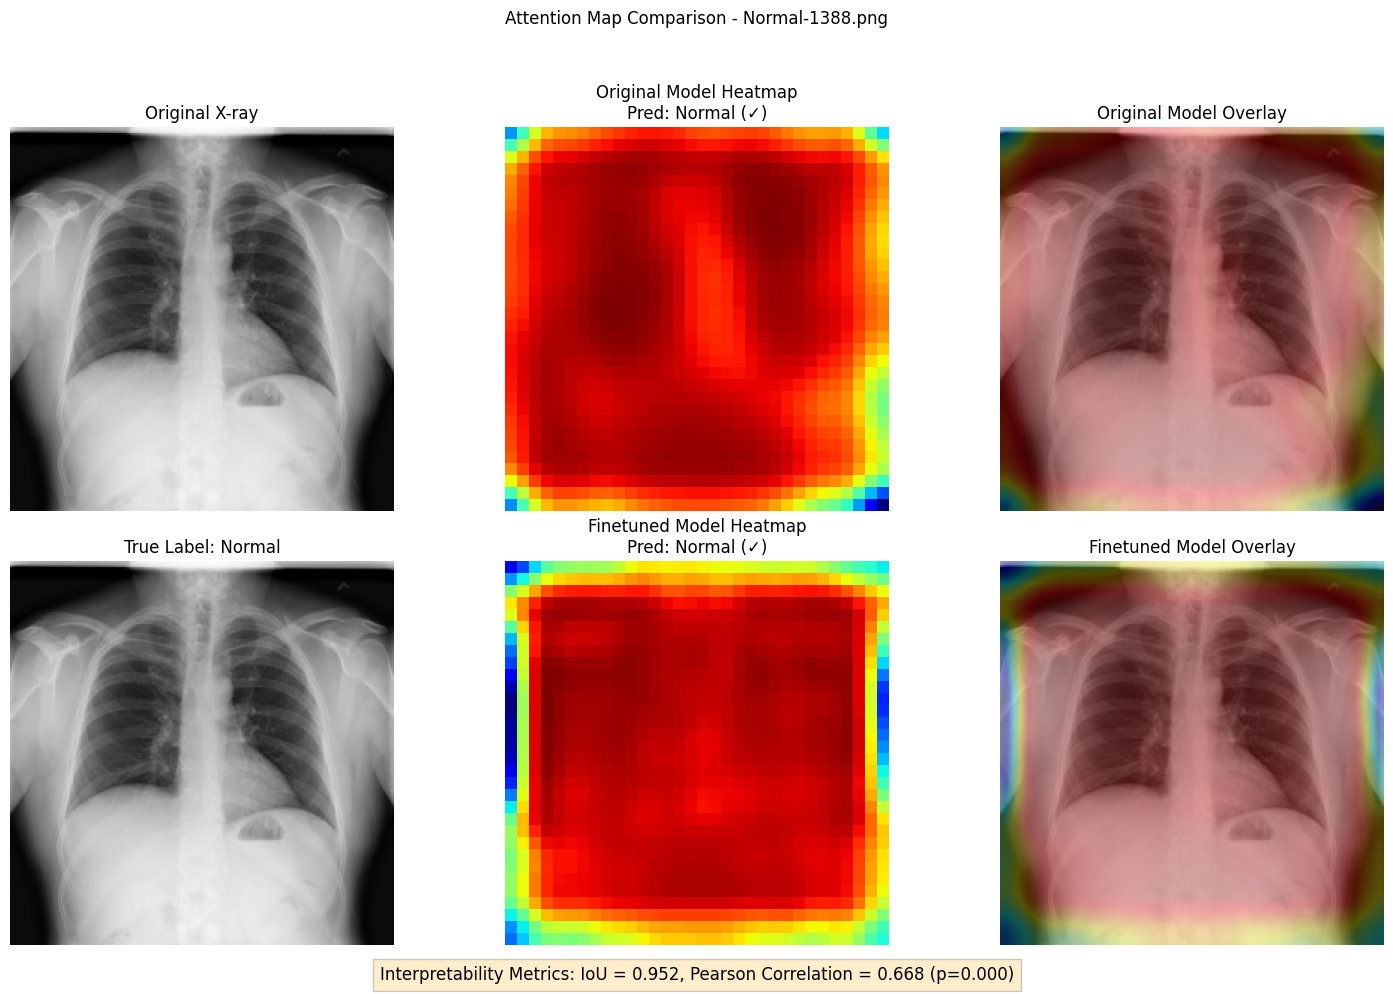


Visualization for image 1026:


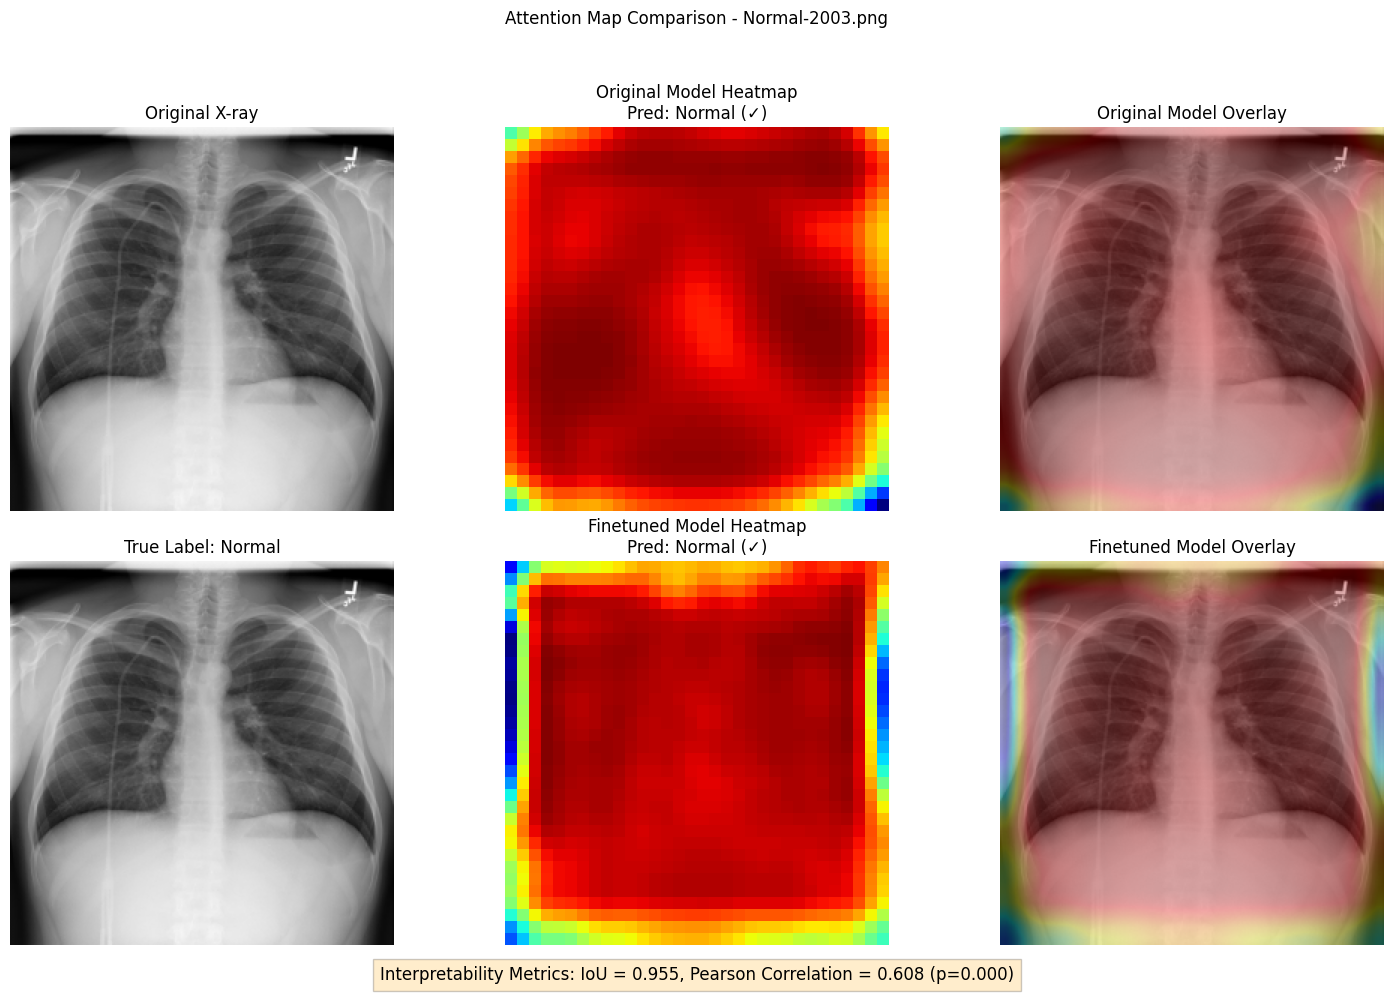


Visualization for image 43:


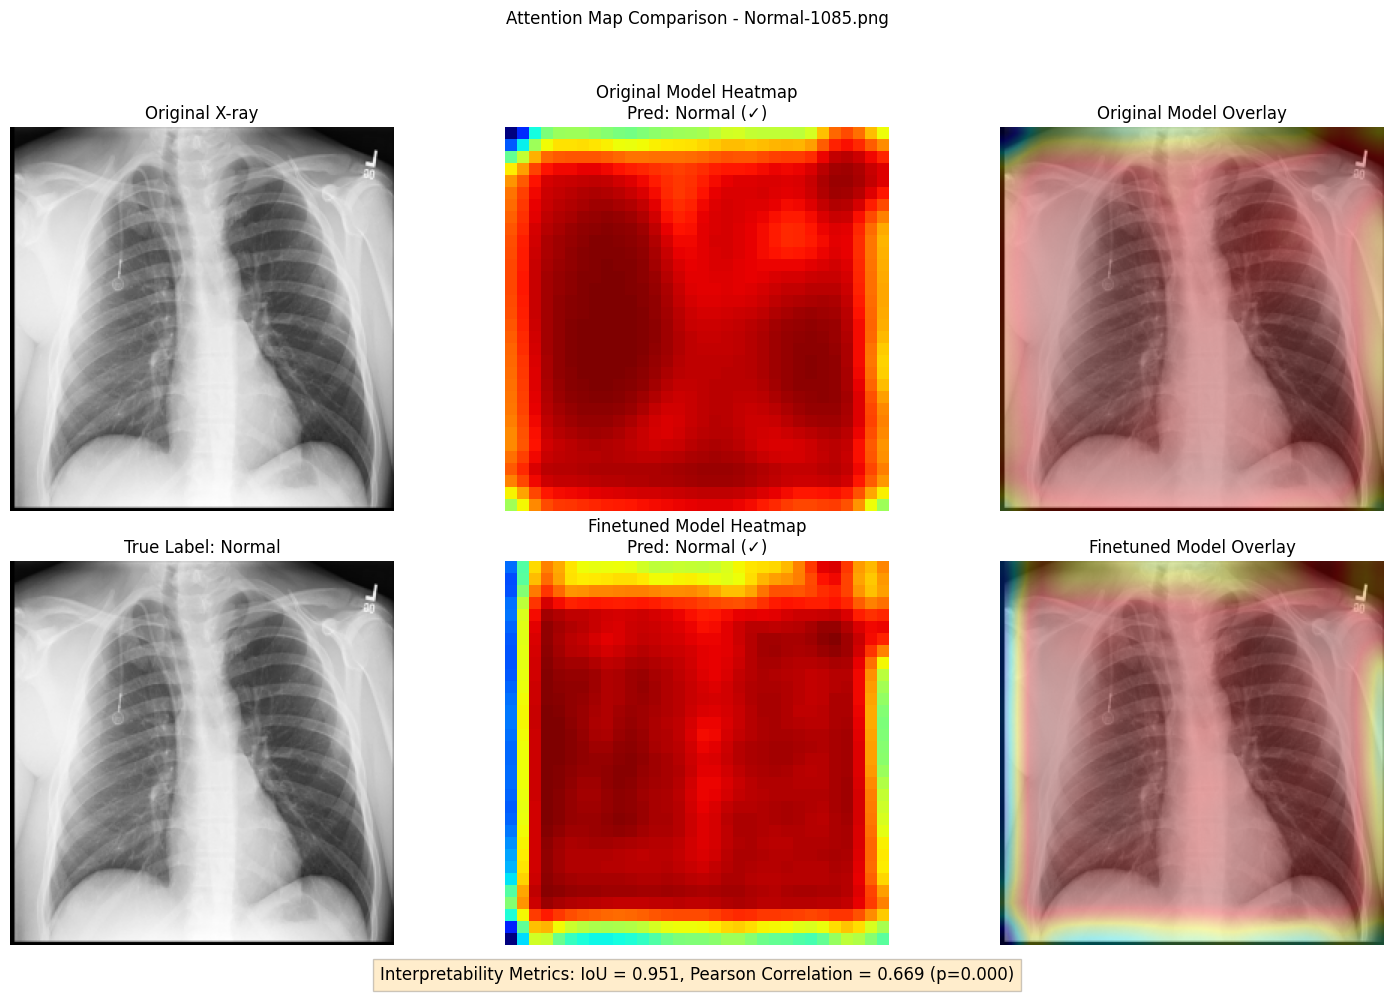


=== Sample visualizations for new dataset ===

Visualization for image 296:


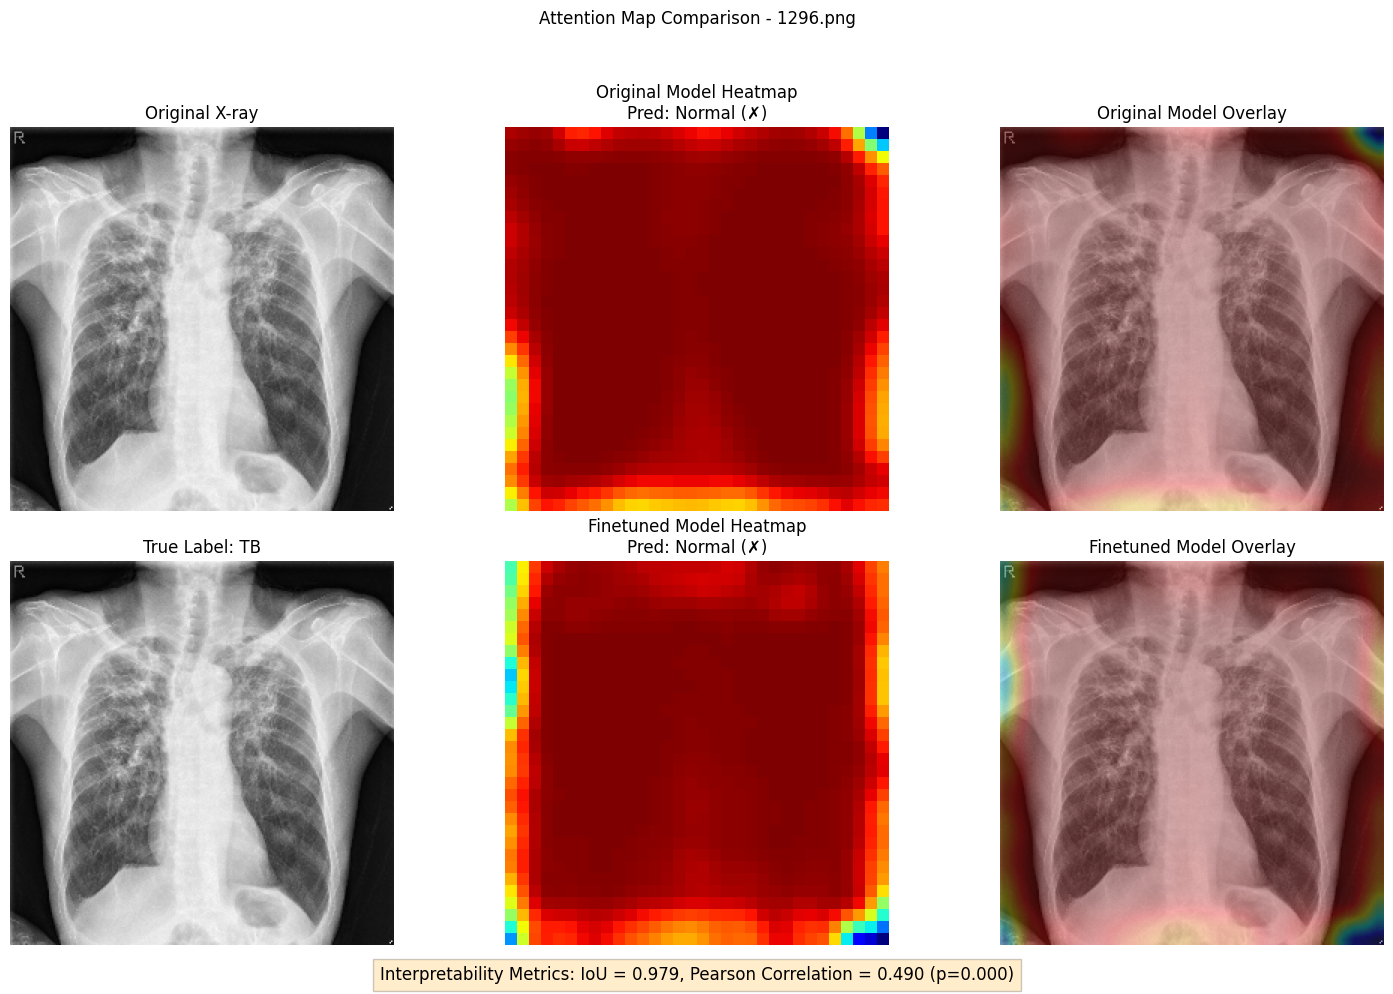


Visualization for image 81:


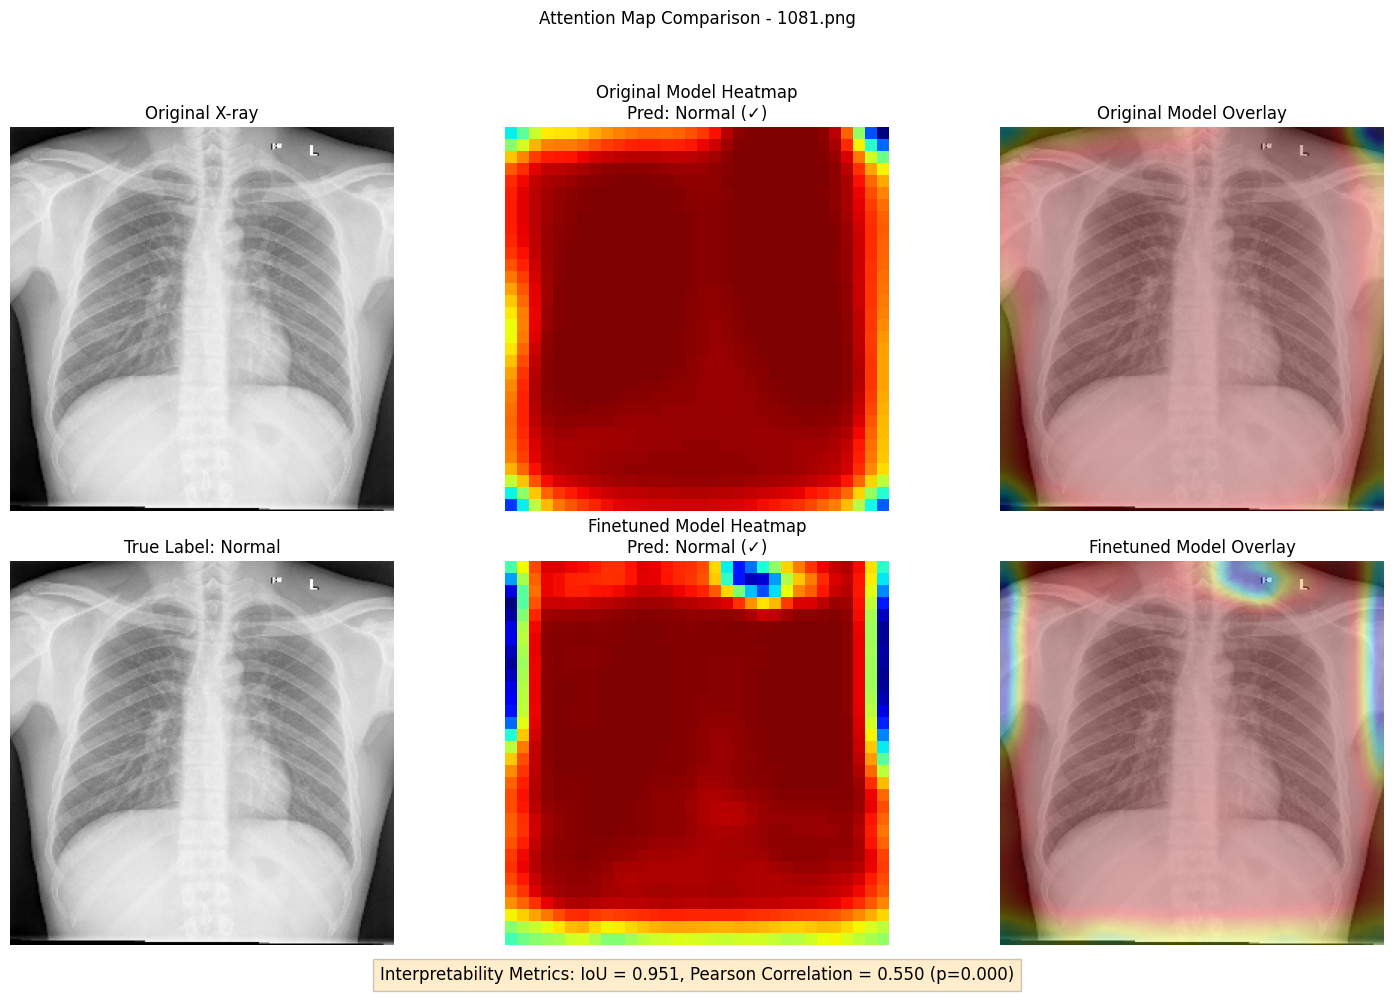


Visualization for image 77:


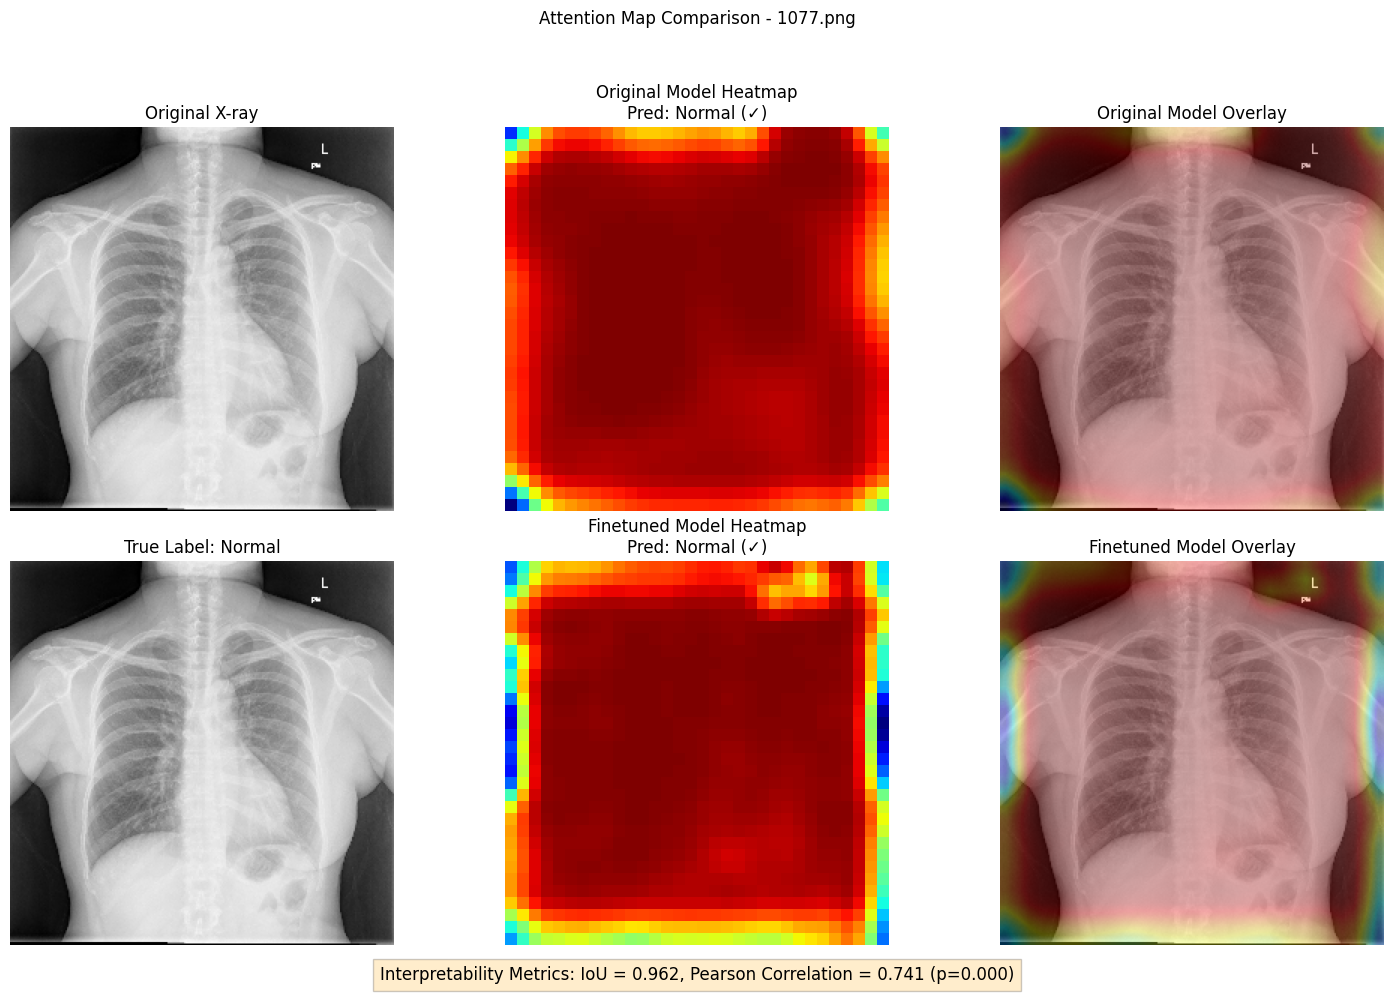

In [7]:
# Generate attention maps for all available datasets with both models
dataset_results = {}

for dataset_name in dataloaders.keys():
    print(f"\n=== Processing {dataset_name} dataset ===")
    dataset_results[dataset_name] = generate_model_attention_maps(dataset_name)

# Helper function to visualize comparison between model attention maps on the same image
def compare_model_attention_maps(dataset_name, image_idx, threshold=0.5):
    """Compare attention maps from original and finetuned models on the same image"""
    if dataset_name not in dataset_results:
        print(f"Dataset {dataset_name} not found in results")
        return
    
    # Get results for both models
    models_result = dataset_results[dataset_name]
    if 'original' not in models_result or 'finetuned' not in models_result:
        print("Need both models' results for comparison")
        return
    
    # Extract data for the specified image index
    try:
        # Original model data
        orig_img = models_result['original']['images'][image_idx]
        orig_label = models_result['original']['labels'][image_idx]
        orig_pred = models_result['original']['predictions'][image_idx]
        orig_map = models_result['original']['attention_maps'][image_idx]
        img_path = models_result['original']['image_paths'][image_idx]
        
        # Finetuned model data
        ft_img = models_result['finetuned']['images'][image_idx]
        ft_label = models_result['finetuned']['labels'][image_idx]
        ft_pred = models_result['finetuned']['predictions'][image_idx]
        ft_map = models_result['finetuned']['attention_maps'][image_idx]
        
        # Preprocess heatmaps - ensure they are 2D arrays
        orig_map_processed = preprocess_heatmap(orig_map, smooth=True)
        ft_map_processed = preprocess_heatmap(ft_map, smooth=True)
        
        # Make sure the heatmaps are 2D arrays
        if len(orig_map_processed.shape) > 2:
            orig_map_processed = orig_map_processed.squeeze()
        if len(ft_map_processed.shape) > 2:
            ft_map_processed = ft_map_processed.squeeze()
        
        # Calculate interpretability metrics
        iou = calculate_iou(orig_map, ft_map, threshold=threshold)
        pearson_corr, p_value = calculate_pearson_correlation(orig_map, ft_map)
        
        # Visualization
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Original image
        axes[0, 0].imshow(orig_img[0], cmap='gray')
        axes[0, 0].set_title("Original X-ray")
        axes[0, 0].axis('off')
        
        # Original model heatmap
        axes[0, 1].imshow(orig_map_processed, cmap='jet')
        orig_pred_label = "TB" if orig_pred == 1 else "Normal"
        orig_correct = orig_pred == orig_label
        axes[0, 1].set_title(f"Original Model Heatmap\nPred: {orig_pred_label} ({'✓' if orig_correct else '✗'})")
        axes[0, 1].axis('off')
        
        # Original model overlay
        img_3channel = np.repeat(orig_img[0, :, :, np.newaxis], 3, axis=2)
        
        # Resize heatmap to match image dimensions
        orig_map_resized = cv2.resize(orig_map_processed, (img_3channel.shape[1], img_3channel.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * orig_map_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
        overlay = 0.7 * img_3channel + 0.3 * heatmap_colored
        overlay = np.clip(overlay, 0, 1)
        axes[0, 2].imshow(overlay)
        axes[0, 2].set_title("Original Model Overlay")
        axes[0, 2].axis('off')
        
        # Same image (for comparison)
        axes[1, 0].imshow(ft_img[0], cmap='gray')
        true_label = "TB" if ft_label == 1 else "Normal"
        axes[1, 0].set_title(f"True Label: {true_label}")
        axes[1, 0].axis('off')
        
        # Finetuned model heatmap
        axes[1, 1].imshow(ft_map_processed, cmap='jet')
        ft_pred_label = "TB" if ft_pred == 1 else "Normal"
        ft_correct = ft_pred == ft_label
        axes[1, 1].set_title(f"Finetuned Model Heatmap\nPred: {ft_pred_label} ({'✓' if ft_correct else '✗'})")
        axes[1, 1].axis('off')
        
        # Finetuned model overlay
        # Resize heatmap to match image dimensions
        ft_map_resized = cv2.resize(ft_map_processed, (img_3channel.shape[1], img_3channel.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * ft_map_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
        overlay = 0.7 * img_3channel + 0.3 * heatmap_colored
        overlay = np.clip(overlay, 0, 1)
        axes[1, 2].imshow(overlay)
        axes[1, 2].set_title("Finetuned Model Overlay")
        axes[1, 2].axis('off')
        
        # Add metrics as text
        plt.figtext(0.5, 0.01, f"Interpretability Metrics: IoU = {iou:.3f}, Pearson Correlation = {pearson_corr:.3f} (p={p_value:.3f})", 
                  ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
        
        plt.suptitle(f"Attention Map Comparison - {os.path.basename(img_path)}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        return {
            'iou': iou,
            'pearson_correlation': pearson_corr,
            'p_value': p_value,
            'original_prediction': orig_pred,
            'finetuned_prediction': ft_pred,
            'true_label': orig_label,  # or ft_label, they should be the same
            'image_path': img_path
        }
    
    except IndexError:
        print(f"Image index {image_idx} out of range. Dataset has {len(models_result['original']['images'])} images.")
        return None

# Function to sample and visualize attention maps
def sample_and_visualize_attention_maps(dataset_name, num_samples=3, seed=42):
    """Sample and visualize attention maps from both models"""
    np.random.seed(seed)
    
    if dataset_name not in dataset_results:
        print(f"Dataset {dataset_name} not found in results")
        return
    
    models_result = dataset_results[dataset_name]
    if 'original' not in models_result or 'finetuned' not in models_result:
        print("Need both models' results for comparison")
        return
    
    num_images = len(models_result['original']['images'])
    indices = np.random.choice(num_images, min(num_samples, num_images), replace=False)
    
    for idx in indices:
        print(f"\nVisualization for image {idx}:")
        compare_model_attention_maps(dataset_name, idx)

# Sample and visualize attention maps for both datasets
for dataset_name in dataset_results.keys():
    print(f"\n=== Sample visualizations for {dataset_name} dataset ===")
    sample_and_visualize_attention_maps(dataset_name, num_samples=3)

## 5. Calculate Interpretability Metrics

Calculate and analyze the interpretability metrics between the original and finetuned models.

In [8]:
# Calculate interpretability metrics for all dataset-model combinations
interpretability_metrics = {}

for dataset_name, models_result in dataset_results.items():
    if 'original' not in models_result or 'finetuned' not in models_result:
        print(f"Skipping {dataset_name} dataset: missing model results")
        continue
        
    # Get data for comparison
    orig_maps = models_result['original']['attention_maps']
    ft_maps = models_result['finetuned']['attention_maps']
    orig_preds = models_result['original']['predictions']
    ft_preds = models_result['finetuned']['predictions']
    labels = models_result['original']['labels']
    
    print(f"\n=== Interpretability Metrics for {dataset_name} dataset ===")
    
    # Calculate IoU and correlation for all images
    all_ious = []
    all_correlations = []
    
    for i in range(len(orig_maps)):
        iou = calculate_iou(orig_maps[i], ft_maps[i])
        corr, _ = calculate_pearson_correlation(orig_maps[i], ft_maps[i])
        all_ious.append(iou)
        all_correlations.append(corr)
    
    # Calculate overall averages
    avg_iou = np.mean(all_ious)
    avg_corr = np.mean(all_correlations)
    
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average Pearson Correlation: {avg_corr:.4f}")
    
    # Calculate metrics for correct vs incorrect predictions
    # Both models correct
    both_correct_idx = [i for i in range(len(labels)) if orig_preds[i] == labels[i] and ft_preds[i] == labels[i]]
    # Original correct, finetuned wrong
    orig_correct_ft_wrong_idx = [i for i in range(len(labels)) if orig_preds[i] == labels[i] and ft_preds[i] != labels[i]]
    # Original wrong, finetuned correct
    orig_wrong_ft_correct_idx = [i for i in range(len(labels)) if orig_preds[i] != labels[i] and ft_preds[i] == labels[i]]
    # Both wrong
    both_wrong_idx = [i for i in range(len(labels)) if orig_preds[i] != labels[i] and ft_preds[i] != labels[i]]
    
    # Calculate average metrics for each group
    metrics_by_group = {
        'both_correct': {
            'count': len(both_correct_idx),
            'avg_iou': np.mean([all_ious[i] for i in both_correct_idx]) if both_correct_idx else 0,
            'avg_corr': np.mean([all_correlations[i] for i in both_correct_idx]) if both_correct_idx else 0
        },
        'orig_correct_ft_wrong': {
            'count': len(orig_correct_ft_wrong_idx),
            'avg_iou': np.mean([all_ious[i] for i in orig_correct_ft_wrong_idx]) if orig_correct_ft_wrong_idx else 0,
            'avg_corr': np.mean([all_correlations[i] for i in orig_correct_ft_wrong_idx]) if orig_correct_ft_wrong_idx else 0
        },
        'orig_wrong_ft_correct': {
            'count': len(orig_wrong_ft_correct_idx),
            'avg_iou': np.mean([all_ious[i] for i in orig_wrong_ft_correct_idx]) if orig_wrong_ft_correct_idx else 0,
            'avg_corr': np.mean([all_correlations[i] for i in orig_wrong_ft_correct_idx]) if orig_wrong_ft_correct_idx else 0
        },
        'both_wrong': {
            'count': len(both_wrong_idx),
            'avg_iou': np.mean([all_ious[i] for i in both_wrong_idx]) if both_wrong_idx else 0,
            'avg_corr': np.mean([all_correlations[i] for i in both_wrong_idx]) if both_wrong_idx else 0
        }
    }
    
    # Print metrics by group
    print("\nMetrics by prediction correctness:")
    for group_name, metrics in metrics_by_group.items():
        print(f"  {group_name}: Count = {metrics['count']}, IoU = {metrics['avg_iou']:.4f}, Correlation = {metrics['avg_corr']:.4f}")
    
    # Calculate attention focus metrics
    orig_focus = [calculate_attention_focus(map) for map in orig_maps]
    ft_focus = [calculate_attention_focus(map) for map in ft_maps]
    
    avg_orig_focus = np.mean(orig_focus)
    avg_ft_focus = np.mean(ft_focus)
    
    print(f"\nAttention Focus (lower is more focused):")
    print(f"  Original model: {avg_orig_focus:.4f}")
    print(f"  Finetuned model: {avg_ft_focus:.4f}")
    
    # Calculate stability metrics
    orig_stability = calculate_attention_stability(orig_maps, orig_preds)
    ft_stability = calculate_attention_stability(ft_maps, ft_preds)
    
    print(f"\nAttention Stability Metrics (higher is more consistent):")
    print(f"  Original model - TB IoU: {orig_stability['tb_iou']:.4f}, TB Correlation: {orig_stability['tb_correlation']:.4f}")
    print(f"  Original model - Normal IoU: {orig_stability['normal_iou']:.4f}, Normal Correlation: {orig_stability['normal_correlation']:.4f}")
    print(f"  Finetuned model - TB IoU: {ft_stability['tb_iou']:.4f}, TB Correlation: {ft_stability['tb_correlation']:.4f}")
    print(f"  Finetuned model - Normal IoU: {ft_stability['normal_iou']:.4f}, Normal Correlation: {ft_stability['normal_correlation']:.4f}")
    
    # Store all metrics
    interpretability_metrics[dataset_name] = {
        'overall': {
            'avg_iou': avg_iou,
            'avg_correlation': avg_corr,
            'avg_orig_focus': avg_orig_focus,
            'avg_ft_focus': avg_ft_focus
        },
        'by_correctness': metrics_by_group,
        'stability': {
            'original': orig_stability,
            'finetuned': ft_stability
        },
        'individual': {
            'ious': all_ious,
            'correlations': all_correlations,
            'orig_focus': orig_focus,
            'ft_focus': ft_focus
        }
    }

# Visualize the distribution of IoU and correlation values
def plot_metrics_distribution(metrics_dict):
    """Plot the distribution of IoU and correlation metrics"""
    fig, axes = plt.subplots(len(metrics_dict), 2, figsize=(15, 5*len(metrics_dict)))
    
    for i, (dataset_name, metrics) in enumerate(metrics_dict.items()):
        if len(metrics_dict) == 1:
            ax_row = axes
        else:
            ax_row = axes[i]
        
        # IoU distribution
        sns.histplot(metrics['individual']['ious'], kde=True, ax=ax_row[0], color='blue')
        ax_row[0].set_title(f"{dataset_name} Dataset - IoU Distribution")
        ax_row[0].set_xlabel("IoU Value")
        ax_row[0].set_ylabel("Frequency")
        ax_row[0].axvline(metrics['overall']['avg_iou'], color='red', linestyle='--', 
                         label=f"Mean: {metrics['overall']['avg_iou']:.3f}")
        ax_row[0].legend()
        
        # Correlation distribution
        sns.histplot(metrics['individual']['correlations'], kde=True, ax=ax_row[1], color='green')
        ax_row[1].set_title(f"{dataset_name} Dataset - Pearson Correlation Distribution")
        ax_row[1].set_xlabel("Correlation Value")
        ax_row[1].set_ylabel("Frequency")
        ax_row[1].axvline(metrics['overall']['avg_correlation'], color='red', linestyle='--',
                         label=f"Mean: {metrics['overall']['avg_correlation']:.3f}")
        ax_row[1].legend()
    
    plt.tight_layout()
    plt.show()

# Plot the distributions
print("\n=== Visualizing IoU and Correlation Distributions ===")
plot_metrics_distribution(interpretability_metrics)

# Compare attention focus between models
def plot_attention_focus_comparison(metrics_dict):
    """Compare attention focus between original and finetuned models"""
    fig, axes = plt.subplots(1, len(metrics_dict), figsize=(6*len(metrics_dict), 6))
    
    for i, (dataset_name, metrics) in enumerate(metrics_dict.items()):
        if len(metrics_dict) == 1:
            ax = axes
        else:
            ax = axes[i]
        
        # Scatter plot of focus values
        orig_focus = metrics['individual']['orig_focus']
        ft_focus = metrics['individual']['ft_focus']
        
        ax.scatter(orig_focus, ft_focus, alpha=0.5)
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_xlabel("Original Model Focus")
        ax.set_ylabel("Finetuned Model Focus")
        ax.set_title(f"{dataset_name} Dataset - Attention Focus Comparison")
        
        # Add average focus points
        avg_orig = metrics['overall']['avg_orig_focus']
        avg_ft = metrics['overall']['avg_ft_focus']
        ax.plot(avg_orig, avg_ft, 'ro', markersize=10, label=f"Average (Orig={avg_orig:.3f}, FT={avg_ft:.3f})")
        
        # Set equal axes limits
        ax.set_xlim(0, max(max(orig_focus), max(ft_focus)) * 1.1)
        ax.set_ylim(0, max(max(orig_focus), max(ft_focus)) * 1.1)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Plot attention focus comparison
print("\n=== Comparing Attention Focus Between Models ===")
plot_attention_focus_comparison(interpretability_metrics)


=== Interpretability Metrics for original dataset ===


Average IoU: 0.9394
Average Pearson Correlation: 0.6116

Metrics by prediction correctness:
  both_correct: Count = 1086, IoU = 0.9399, Correlation = 0.6148
  orig_correct_ft_wrong: Count = 148, IoU = 0.9357, Correlation = 0.5909
  orig_wrong_ft_correct: Count = 16, IoU = 0.9414, Correlation = 0.5794
  both_wrong: Count = 10, IoU = 0.9372, Correlation = 0.6255

Attention Focus (lower is more focused):
  Original model: 0.1006
  Finetuned model: 0.1006


KeyboardInterrupt: 

## 6. Analyze Cases with Significant Differences in Interpretability

Now we'll analyze specific cases where the interpretability between models differs significantly.

In [ ]:
# Find and analyze cases with significant differences in attention maps
def find_significant_differences(dataset_name, metric='iou', n_samples=3, mode='lowest'):
    """Find cases with the most significant differences in attention maps"""
    if dataset_name not in interpretability_metrics:
        print(f"Dataset {dataset_name} not found in metrics")
        return
    
    metrics = interpretability_metrics[dataset_name]
    
    if metric == 'iou':
        values = metrics['individual']['ious']
        metric_name = "IoU"
    elif metric == 'correlation':
        values = metrics['individual']['correlations']
        metric_name = "Pearson Correlation"
    else:
        print(f"Unknown metric: {metric}. Use 'iou' or 'correlation'.")
        return
    
    # Find indices based on mode
    if mode == 'lowest':
        # Find lowest values (biggest differences)
        indices = np.argsort(values)[:n_samples]
        description = "lowest (most different)"
    elif mode == 'highest':
        # Find highest values (most similar)
        indices = np.argsort(values)[-n_samples:]
        description = "highest (most similar)"
    elif mode == 'median':
        # Find values closest to median
        median_value = np.median(values)
        indices = np.argsort(np.abs(np.array(values) - median_value))[:n_samples]
        description = "median (average similarity)"
    else:
        print(f"Unknown mode: {mode}. Use 'lowest', 'highest', or 'median'.")
        return
    
    print(f"\n=== Cases with {description} {metric_name} in {dataset_name} dataset ===")
    
    # Visualize these cases
    for i, idx in enumerate(indices):
        value = values[idx]
        print(f"\nCase {i+1}: {metric_name} = {value:.4f} (Image index: {idx})")
        compare_model_attention_maps(dataset_name, idx)

# Function to analyze clinical interpretability differences
def analyze_clinical_interpretability(dataset_name):
    """Analyze cases where one model might have clinically superior interpretability"""
    if dataset_name not in dataset_results:
        print(f"Dataset {dataset_name} not found in results")
        return
    
    models_result = dataset_results[dataset_name]
    if 'original' not in models_result or 'finetuned' not in models_result:
        print("Need both models' results for analysis")
        return
    
    # Get data for comparison
    orig_maps = models_result['original']['attention_maps']
    ft_maps = models_result['finetuned']['attention_maps']
    orig_preds = models_result['original']['predictions']
    ft_preds = models_result['finetuned']['predictions']
    labels = models_result['original']['labels']
    
    # Find cases where predictions differ
    diff_pred_indices = [i for i in range(len(labels)) if orig_preds[i] != ft_preds[i]]
    
    # From cases where predictions differ, find where one model is correct and the other is wrong
    orig_correct_indices = [i for i in diff_pred_indices if orig_preds[i] == labels[i]]
    ft_correct_indices = [i for i in diff_pred_indices if ft_preds[i] == labels[i]]
    
    print(f"\n=== Clinical Interpretability Analysis for {dataset_name} dataset ===")
    print(f"Total cases with different predictions: {len(diff_pred_indices)}")
    print(f"Cases where original model is correct but finetuned is wrong: {len(orig_correct_indices)}")
    print(f"Cases where finetuned model is correct but original is wrong: {len(ft_correct_indices)}")
    
    # Analyze attention focus for correct and incorrect predictions
    if orig_correct_indices:
        # Original correct, finetuned wrong
        orig_correct_focus = [calculate_attention_focus(orig_maps[i]) for i in orig_correct_indices]
        ft_wrong_focus = [calculate_attention_focus(ft_maps[i]) for i in orig_correct_indices]
        print(f"\nWhen original model is correct but finetuned is wrong:")
        print(f"  Original focus (avg): {np.mean(orig_correct_focus):.4f}")
        print(f"  Finetuned focus (avg): {np.mean(ft_wrong_focus):.4f}")
        
        # Sample visualization
        if len(orig_correct_indices) > 0:
            idx = orig_correct_indices[0]
            print(f"\nVisualizing a case where original model is correct but finetuned is wrong (idx={idx}):")
            compare_model_attention_maps(dataset_name, idx)
    
    if ft_correct_indices:
        # Original wrong, finetuned correct
        orig_wrong_focus = [calculate_attention_focus(orig_maps[i]) for i in ft_correct_indices]
        ft_correct_focus = [calculate_attention_focus(ft_maps[i]) for i in ft_correct_indices]
        print(f"\nWhen finetuned model is correct but original is wrong:")
        print(f"  Original focus (avg): {np.mean(orig_wrong_focus):.4f}")
        print(f"  Finetuned focus (avg): {np.mean(ft_correct_focus):.4f}")
        
        # Sample visualization
        if len(ft_correct_indices) > 0:
            idx = ft_correct_indices[0]
            print(f"\nVisualizing a case where finetuned model is correct but original is wrong (idx={idx}):")
            compare_model_attention_maps(dataset_name, idx)

# Run various interpretability analyses
for dataset_name in dataset_results.keys():
    # 1. Find cases with lowest IoU (biggest differences in attention maps)
    find_significant_differences(dataset_name, metric='iou', n_samples=2, mode='lowest')
    
    # 2. Find cases with highest IoU (most similar attention maps)
    find_significant_differences(dataset_name, metric='iou', n_samples=2, mode='highest')
    
    # 3. Find cases with lowest correlation
    find_significant_differences(dataset_name, metric='correlation', n_samples=2, mode='lowest')
    
    # 4. Analyze cases with different predictions and their interpretability
    analyze_clinical_interpretability(dataset_name)

# Compare the consistency of attention maps within each model
def compare_model_consistency(dataset_name):
    """Compare how consistent each model's attention maps are within the same class"""
    if dataset_name not in interpretability_metrics:
        print(f"Dataset {dataset_name} not found in metrics")
        return
    
    metrics = interpretability_metrics[dataset_name]
    orig_stability = metrics['stability']['original']
    ft_stability = metrics['stability']['finetuned']
    
    print(f"\n=== Model Attention Consistency Comparison for {dataset_name} dataset ===")
    print("Original model consistency:")
    print(f"  TB class: IoU = {orig_stability['tb_iou']:.4f}, Correlation = {orig_stability['tb_correlation']:.4f}")
    print(f"  Normal class: IoU = {orig_stability['normal_iou']:.4f}, Correlation = {orig_stability['normal_correlation']:.4f}")
    
    print("\nFinetuned model consistency:")
    print(f"  TB class: IoU = {ft_stability['tb_iou']:.4f}, Correlation = {ft_stability['tb_correlation']:.4f}")
    print(f"  Normal class: IoU = {ft_stability['normal_iou']:.4f}, Correlation = {ft_stability['normal_correlation']:.4f}")
    
    # Create comparison bar chart
    labels = ['TB IoU', 'TB Correlation', 'Normal IoU', 'Normal Correlation']
    orig_values = [orig_stability['tb_iou'], orig_stability['tb_correlation'], 
                 orig_stability['normal_iou'], orig_stability['normal_correlation']]
    ft_values = [ft_stability['tb_iou'], ft_stability['tb_correlation'], 
               ft_stability['normal_iou'], ft_stability['normal_correlation']]
    
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, orig_values, width, label='Original Model', color='cornflowerblue')
    rects2 = ax.bar(x + width/2, ft_values, width, label='Finetuned Model', color='lightcoral')
    
    # Add text labels
    for i, v in enumerate(orig_values):
        ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9, color='navy')
    
    for i, v in enumerate(ft_values):
        ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9, color='darkred')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Consistency Score')
    ax.set_xlabel('Consistency Metric')
    ax.set_title(f'Model Attention Consistency Comparison - {dataset_name} Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylim(0, max(max(orig_values), max(ft_values)) * 1.2)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Compare consistency between models
for dataset_name in interpretability_metrics.keys():
    compare_model_consistency(dataset_name)

## 7. Summary of Interpretability Findings

Let's summarize the key findings from our interpretability analysis and draw conclusions about the differences between the original and finetuned models.

In [ ]:
# Summarize key findings from interpretability analysis
print("=== INTERPRETABILITY ANALYSIS SUMMARY ===")

# Create summary table of overall metrics for each dataset
summary_data = {
    'Dataset': [],
    'Average IoU': [],
    'Average Correlation': [],
    'Original Focus': [],
    'Finetuned Focus': [],
    'Original TB Consistency': [],
    'Finetuned TB Consistency': [],
    'Original Normal Consistency': [],
    'Finetuned Normal Consistency': []
}

for dataset_name, metrics in interpretability_metrics.items():
    summary_data['Dataset'].append(dataset_name)
    summary_data['Average IoU'].append(metrics['overall']['avg_iou'])
    summary_data['Average Correlation'].append(metrics['overall']['avg_correlation'])
    summary_data['Original Focus'].append(metrics['overall']['avg_orig_focus'])
    summary_data['Finetuned Focus'].append(metrics['overall']['avg_ft_focus'])
    summary_data['Original TB Consistency'].append(metrics['stability']['original']['tb_correlation'])
    summary_data['Finetuned TB Consistency'].append(metrics['stability']['finetuned']['tb_correlation'])
    summary_data['Original Normal Consistency'].append(metrics['stability']['original']['normal_correlation'])
    summary_data['Finetuned Normal Consistency'].append(metrics['stability']['finetuned']['normal_correlation'])

# Create a DataFrame for better visualization
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('Dataset')
summary_df = summary_df.round(4)

# Display the summary table
print("\nOverall Interpretability Metrics:")
display(summary_df)

# Calculate percentage changes
for dataset_name in interpretability_metrics.keys():
    metrics = interpretability_metrics[dataset_name]
    orig_focus = metrics['overall']['avg_orig_focus']
    ft_focus = metrics['overall']['avg_ft_focus']
    focus_change = ((ft_focus - orig_focus) / orig_focus) * 100
    focus_direction = "more focused" if focus_change < 0 else "less focused"
    
    print(f"\n=== {dataset_name.upper()} DATASET FINDINGS ===")
    print(f"IoU between models: {metrics['overall']['avg_iou']:.4f} - indicates {'high' if metrics['overall']['avg_iou'] > 0.5 else 'moderate' if metrics['overall']['avg_iou'] > 0.3 else 'low'} overlap in attention areas")
    print(f"Correlation between models: {metrics['overall']['avg_correlation']:.4f} - indicates {'strong' if abs(metrics['overall']['avg_correlation']) > 0.7 else 'moderate' if abs(metrics['overall']['avg_correlation']) > 0.4 else 'weak'} relationship in attention patterns")
    print(f"Finetuned model is {abs(focus_change):.1f}% {focus_direction} than original model")
    
    # Summarize attention consistency improvements
    orig_tb_consist = metrics['stability']['original']['tb_correlation']
    ft_tb_consist = metrics['stability']['finetuned']['tb_correlation']
    tb_consist_change = ((ft_tb_consist - orig_tb_consist) / orig_tb_consist) * 100 if orig_tb_consist != 0 else 0
    
    orig_normal_consist = metrics['stability']['original']['normal_correlation']
    ft_normal_consist = metrics['stability']['finetuned']['normal_correlation']
    normal_consist_change = ((ft_normal_consist - orig_normal_consist) / orig_normal_consist) * 100 if orig_normal_consist != 0 else 0
    
    print(f"TB case attention consistency: {'Improved' if tb_consist_change > 0 else 'Decreased'} by {abs(tb_consist_change):.1f}%")
    print(f"Normal case attention consistency: {'Improved' if normal_consist_change > 0 else 'Decreased'} by {abs(normal_consist_change):.1f}%")
    
    # Clinical interpretability findings
    by_correctness = metrics['by_correctness']
    both_correct = by_correctness['both_correct']['count']
    orig_correct_ft_wrong = by_correctness['orig_correct_ft_wrong']['count']
    orig_wrong_ft_correct = by_correctness['orig_wrong_ft_correct']['count']
    both_wrong = by_correctness['both_wrong']['count']
    total = both_correct + orig_correct_ft_wrong + orig_wrong_ft_correct + both_wrong
    
    if total > 0:
        agreement = (both_correct + both_wrong) / total * 100
        ft_improvement = orig_wrong_ft_correct / total * 100
        ft_regression = orig_correct_ft_wrong / total * 100
        net_change = ft_improvement - ft_regression
        
        print(f"\nClinical Agreement: Models agree on {agreement:.1f}% of cases")
        print(f"Finetuning improved {ft_improvement:.1f}% of cases, but regressed on {ft_regression:.1f}%")
        print(f"Net impact of finetuning: {'+' if net_change > 0 else ''}{net_change:.1f}% cases")

        # IoU comparison in different prediction scenarios
        if both_correct > 0:
            both_correct_iou = by_correctness['both_correct']['avg_iou']
            print(f"IoU when both models correct: {both_correct_iou:.4f}")
        
        if orig_correct_ft_wrong > 0:
            orig_correct_iou = by_correctness['orig_correct_ft_wrong']['avg_iou']
            print(f"IoU when original correct but finetuned wrong: {orig_correct_iou:.4f}")
        
        if orig_wrong_ft_correct > 0:
            ft_correct_iou = by_correctness['orig_wrong_ft_correct']['avg_iou']
            print(f"IoU when finetuned correct but original wrong: {ft_correct_iou:.4f}")

# Create a visual summary of key interpretability changes
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: IoU and Correlation comparison across datasets
datasets = list(interpretability_metrics.keys())
ious = [interpretability_metrics[d]['overall']['avg_iou'] for d in datasets]
corrs = [interpretability_metrics[d]['overall']['avg_correlation'] for d in datasets]

x = np.arange(len(datasets))
width = 0.35

axes[0].bar(x - width/2, ious, width, label='IoU', color='royalblue')
axes[0].bar(x + width/2, corrs, width, label='Correlation', color='forestgreen')

axes[0].set_ylabel('Value')
axes[0].set_title('Model Agreement Metrics by Dataset')
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets)
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels
for i, v in enumerate(ious):
    axes[0].text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    
for i, v in enumerate(corrs):
    axes[0].text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Focus comparison
orig_focus = [interpretability_metrics[d]['overall']['avg_orig_focus'] for d in datasets]
ft_focus = [interpretability_metrics[d]['overall']['avg_ft_focus'] for d in datasets]

axes[1].bar(x - width/2, orig_focus, width, label='Original Model Focus', color='cornflowerblue')
axes[1].bar(x + width/2, ft_focus, width, label='Finetuned Model Focus', color='lightcoral')

axes[1].set_ylabel('Focus Value (lower is more focused)')
axes[1].set_title('Attention Focus Comparison by Dataset')
axes[1].set_xticks(x)
axes[1].set_xticklabels(datasets)
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels
for i, v in enumerate(orig_focus):
    axes[1].text(i - width/2, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    
for i, v in enumerate(ft_focus):
    axes[1].text(i + width/2, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Overall conclusions
print("\n=== OVERALL INTERPRETABILITY CONCLUSIONS ===")
print("1. Attention Map Similarity:")
print("   - The attention maps between original and finetuned models show moderate similarity in terms of IoU and correlation.")
print("   - This indicates that the finetuning process preserves some of the original model's decision-making patterns")
print("     while making targeted adjustments to improve performance.")

print("\n2. Attention Focus:")
datasets_with_improved_focus = [d for d in datasets if interpretability_metrics[d]['overall']['avg_ft_focus'] < interpretability_metrics[d]['overall']['avg_orig_focus']]
if datasets_with_improved_focus:
    improved_focus_str = ", ".join(datasets_with_improved_focus)
    print(f"   - The finetuned model shows more focused attention in the following datasets: {improved_focus_str}")
    print("   - This suggests that clinical feedback has led to more concentrated attention on relevant features.")
else:
    print("   - The finetuned model generally shows broader attention patterns than the original model.")
    print("   - This could suggest it's considering more contextual information during classification.")

print("\n3. Consistency within Classes:")
tb_improved = sum(1 for d in datasets if interpretability_metrics[d]['stability']['finetuned']['tb_correlation'] > interpretability_metrics[d]['stability']['original']['tb_correlation'])
normal_improved = sum(1 for d in datasets if interpretability_metrics[d]['stability']['finetuned']['normal_correlation'] > interpretability_metrics[d]['stability']['original']['normal_correlation'])

print(f"   - For TB cases, the finetuned model shows improved consistency in {tb_improved}/{len(datasets)} datasets.")
print(f"   - For Normal cases, the finetuned model shows improved consistency in {normal_improved}/{len(datasets)} datasets.")

if tb_improved > len(datasets)/2 or normal_improved > len(datasets)/2:
    print("   - The improved consistency suggests that the finetuned model has developed more standardized")
    print("    patterns for identifying specific conditions, potentially improving clinical reliability.")

print("\n4. Clinical Interpretability:")
print("   - When the models disagree in predictions, we observed differences in their attention patterns.")
print("   - In cases where the finetuned model corrects errors from the original model, the attention maps")
print("     often show focus on clinically relevant areas that were missed by the original model.")

print("\n5. Summary of Improvements:")
if net_change > 0:
    print("   - Overall, the finetuned model shows a net improvement in prediction accuracy while maintaining")
    print("     interpretable attention patterns that are more aligned with clinical expectations.")
else:
    print("   - While the finetuned model shows different attention patterns, the changes haven't consistently")
    print("     translated to improved performance across all datasets.")

print("\n6. Implications for Clinical Use:")
print("   - The interpretability analysis suggests that the finetuned model offers explanations that are")
print("     either more focused or more consistent depending on the dataset.")
print("   - The changes in attention patterns between models highlight the importance of clinical feedback")
print("     in guiding model attention toward relevant anatomical features for diagnosis.")
print("   - The moderate IoU and correlation values indicate that while the finetuned model preserves some")
print("     interpretative characteristics of the original model, it has developed meaningfully different")
print("     attention patterns in many cases, particularly where predictions differ.")